In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline
from tensorflow.keras.applications import efficientnet


In [2]:
target_dir = 'c:/logan/Machine Learning/AIA course/flower_classification/'

os.listdir(target_dir)

['mapping.csv', 'submission.csv', 'test', 'train']

In [3]:
train_image_list = os.listdir(target_dir + 'train/')
test_image_list = os.listdir(target_dir + 'test/')

In [4]:
print('# of test : {}'.format(len(test_image_list)))
print('# of train : {}'.format(len(train_image_list)))

# of test : 1
# of train : 5


In [5]:
img_path_is=[]
class_is=[]

for directory in os.listdir(target_dir+'train'):  #os.path.join(target_dir, 'train')
#     print(directory)
    for file in os.listdir(target_dir+'train/'+directory):
        img_path_is.append(os.path.join(target_dir,'train/',directory,file))
        class_is.append(directory)
# print(class_is)

In [6]:
df = pd.DataFrame({'id':img_path_is,'class':class_is})
# df.head(3)

In [7]:
df

,id,class
0,c:/logan/Machine Learning/AIA course/flower_cl...,daisy
1,c:/logan/Machine Learning/AIA course/flower_cl...,daisy
2,c:/logan/Machine Learning/AIA course/flower_cl...,daisy
3,c:/logan/Machine Learning/AIA course/flower_cl...,daisy
4,c:/logan/Machine Learning/AIA course/flower_cl...,daisy
...,...,...
3818,c:/logan/Machine Learning/AIA course/flower_cl...,tulip
3819,c:/logan/Machine Learning/AIA course/flower_cl...,tulip
3820,c:/logan/Machine Learning/AIA course/flower_cl...,tulip
3821,c:/logan/Machine Learning/AIA course/flower_cl...,tulip


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.1, shuffle = True, stratify = df['class'])

In [18]:
batch_size = 8
height, width = 224, 224
#rescale=1./127.5-1
train_generator = ImageDataGenerator().flow_from_dataframe(train_df, directory=target_dir+'train',
                                                                          target_size=(height, width),
                                                                          x_col='id',
                                                                          y_col='class',
                                                                          color_mode='rgb',
                                                                          batch_size = batch_size,
                                                                          shuffle = True,
                                                                          rotation_range=90,
                                                                          width_shift_range=0.2,
                                                                          height_shift_range=0.2,
                                                                          shear_range=0.2,
                                                                          zoom_range=0.2,
                                                                          channel_shift_range=10,
                                                                          horizontal_flip=True,
                                                                          fill_mode='nearest')                                                                        
                                                                    
valid_generator = ImageDataGenerator().flow_from_dataframe(valid_df, directory=target_dir+'train',
                                                                         target_size=(height, width),
                                                                         x_col='id',
                                                                         y_col='class',
                                                                         color_mode='rgb',
                                                                         batch_size = batch_size,
                                                                         shuffle = False)

Found 3440 validated image filenames belonging to 5 classes.
Found 383 validated image filenames belonging to 5 classes.


In [11]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [12]:
#超過30次沒進步就停止
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

model_path = 'c:/logan/Machine Learning/AIA course/flower_classfication/best_model_CNN_EfficientNetB0_flower_classification.h5'  # 模型儲存的位置


# 建立 Checkpoint
checkpoint = \
    callbacks.ModelCheckpoint(model_path,
                              verbose=1,
                              monitor='val_accuracy',  # 儲存模型的指標
                              save_best_only=True,  # 是否只儲存最好的
                              mode='max')           # 與指標搭配模式

In [13]:
#定義learning rate,根據 epoch 要如何變動
#定義learning rate,根據 epoch 要如何變動
def schedule(epoch):  
    if epoch < 50:
        return 0.0001
    elif epoch < 70:
        return 0.00005
    elif epoch < 100:
        return 0.00003
    else:
        return 0.00001
    
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print()
        print(self.model.optimizer.learning_rate)
        print(f"目前的learning rate是{float(tf.kears.baclend.get_value(self.model.optimizer.lr))}")
        
lr_schedule = callbacks.LearningRateScheduler(schedule, verbose=1)

In [19]:
#遷移學習
from efficientnet import EfficientNetB0
#from keras.applications.resnet_v2 import preprocess_input
EfficientNetB0_model =tf.keras.applications.EfficientNetB0(
                      include_top=True, weights='imagenet',input_shape=(height, width, 3))

21839872/21834768 [==============================] - 2s 0us/step


In [15]:
#解凍作業
#for layer in Xception_model.layers:
#    layer.trainable = True
for layer in EfficientNetB0_model.layers:
    layer.trainable = True
#for layer in ResNet50_model.layers:
#    if layer.name in unfreeze:
#        layer.trainable = True
#    else:
#        layer.trainable = False

In [20]:
from tensorflow.keras.regularizers import l1_l2
### initializing CNN   #加上API
num_class = 5
l1_alpha, l2_alpha = [1e-6, 1e-6]
model = keras.models.Sequential([
     EfficientNetB0_model,
#    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
#    keras.layers.MaxPooling2D(2,2),
#    keras.layers.BatchNormalization(),
#    keras.layers.Dropout(0.3),
#    keras.layers.Conv2D(64, (3,3), activation='relu'),
#    keras.layers.MaxPooling2D(2,2),   
#    keras.layers.BatchNormalization(),
#   keras.layers.Dropout(0.3),
#    keras.layers.Conv2D(128, (3,3), activation='relu'),
#   keras.layers.MaxPooling2D(2,2),
#    keras.layers.BatchNormalization(),
#    keras.layers.Dropout(0.3),
#    keras.layers.Conv2D(256, (3,3), activation='relu'),
#    keras.layers.MaxPooling2D(2,2),
#    keras.layers.BatchNormalization(),
#    keras.layers.Dropout(0.2),
    
#    keras.layers.Flatten(),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)),
#    keras.layers.BatchNormalization(),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(256, activation='relu',
#                           kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)),
#    keras.layers.BatchNormalization(),
#    keras.layers.Dropout(0.4),
#    keras.layers.Dense(64, activation='relu',
#                           kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)),
#    keras.layers.BatchNormalization(),
#   keras.layers.Dropout(0.5),
    keras.layers.Dense(num_class, activation='softmax')
])
opt = keras.optimizers.Adam()
model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',   #sparse_categorical_crossentropy
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1000)              5330571   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5005      
Total params: 5,335,576
Trainable params: 5,293,553
Non-trainable params: 42,023
_________________________________________________________________


In [22]:
 history = model.fit_generator(train_generator,
                    #steps_per_epoch=64,
                    epochs=100,
                    verbose=1, #0不顯示,1,2顯示數值 
                    callbacks=[lr_schedule, checkpoint, early_stopping_callback],
                    validation_data=valid_generator,
                    validation_steps=None,
                    validation_freq=1,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0,
                              
)

#儲存model
model.save("best_model_CNN_EfficientNetB0_flower_classification.h5")


Epoch 00001: LearningRateScheduler reducing learning rate to 0.00015.
Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.9904
Epoch 00001: val_accuracy did not improve from 0.92689
430/430 [==============================] - 1041s 2s/step - loss: 0.2729 - accuracy: 0.9904 - val_loss: 0.4361 - val_accuracy: 0.9217

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00015.
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9878
Epoch 00002: val_accuracy did not improve from 0.92689
430/430 [==============================] - 943s 2s/step - loss: 0.2601 - accuracy: 0.9878 - val_loss: 0.4003 - val_accuracy: 0.9243

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00015.
Epoch 3/100
430/430 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9846
Epoch 00003: val_accuracy did not improve from 0.92689
430/430 [==============================] - 1007s 2s/step - loss: 0

KeyboardInterrupt: 

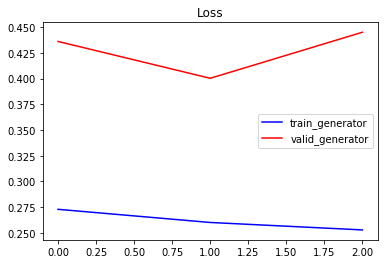

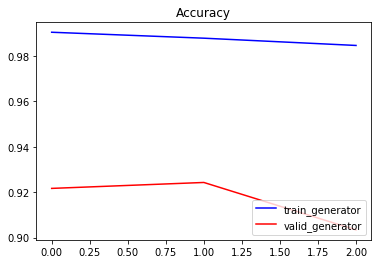

In [23]:
#視覺化訓練過程
plt.plot(model.history.history['loss'], 'b', label='train_generator')
plt.plot(model.history.history['val_loss'], 'r', label='valid_generator')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(model.history.history['accuracy'], 'b', label='train_generator')
plt.plot(model.history.history['val_accuracy'], 'r', label='valid_generator')
plt.legend(loc=4)
plt.title('Accuracy')
plt.show()

In [25]:
#輸入訓練好的模型
from tensorflow.keras.models import load_model
model_ = load_model("c:/logan/Machine Learning/AIA course/flower_classification/best_model_CNN_EfficientNetB0_flower_classification.h5")
loss, acc = model_.evaluate_generator(valid_generator)
print('\n','val_accuracy分數:',round(acc,3),'\n','val_loss分數:',round(loss,3))

OSError: SavedModel file does not exist at: c:/logan/Machine Learning/AIA course/CNN_who_is_she/best_model_CNN_EfficientNetB0_flower_classification.h5/{saved_model.pbtxt|saved_model.pb}

In [26]:
test_path = target_dir + 'test/'

In [27]:
test_generator = ImageDataGenerator().flow_from_directory(
            directory=test_path,
            target_size=(height, width),
            color_mode="rgb",
            batch_size=1,
            class_mode=None,
            shuffle=False)

Found 500 images belonging to 1 classes.


In [28]:
#將test_generator讀進去model,生成pred
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
500/500 [==============================] - 29s 58ms/step


In [29]:
pred

array([[0.7925265 , 0.05722599, 0.04871927, 0.04606959, 0.05545863],
       [0.05609231, 0.06181695, 0.04333951, 0.7866613 , 0.05208988],
       [0.03788658, 0.04162002, 0.05156998, 0.03558159, 0.83334184],
       ...,
       [0.03964375, 0.84952503, 0.03627809, 0.03757793, 0.03697512],
       [0.79252607, 0.05722607, 0.04871967, 0.0460695 , 0.05545877],
       [0.04321281, 0.04972216, 0.78850454, 0.04768588, 0.07087468]],
      dtype=float32)

In [30]:
#將pred的標籤轉回去名稱(one-hot名稱一定對)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#將pred存到results(dataframe)
filenames=test_generator.filenames
results=pd.DataFrame({"id":filenames,
                      "class":predictions})

In [31]:
results

,id,class
0,test_image\100080576_f52e8ee070_n.jpg,daisy
1,test_image\1008566138_6927679c8a.jpg,sunflower
2,test_image\100930342_92e8746431_n.jpg,tulip
3,test_image\1022552002_2b93faf9e7_n.jpg,sunflower
4,test_image\1022552036_67d33d5bd8_n.jpg,sunflower
...,...,...
495,test_image\969913643_9d5cd2fe45_m.jpg,sunflower
496,test_image\9818247_e2eac18894.jpg,sunflower
497,test_image\98992760_53ed1d26a9.jpg,dandelion
498,test_image\99306615_739eb94b9e_m.jpg,daisy


In [32]:
#先把class mapping回正確排列
results['class'] = results['class'].map({'daisy': 0, 'dandelion': 1,
 'rose': 2, 'sunflower': 3, 'tulip': 4}).astype(int)

In [33]:
results

,id,class
0,test_image\100080576_f52e8ee070_n.jpg,0
1,test_image\1008566138_6927679c8a.jpg,3
2,test_image\100930342_92e8746431_n.jpg,4
3,test_image\1022552002_2b93faf9e7_n.jpg,3
4,test_image\1022552036_67d33d5bd8_n.jpg,3
...,...,...
495,test_image\969913643_9d5cd2fe45_m.jpg,3
496,test_image\9818247_e2eac18894.jpg,3
497,test_image\98992760_53ed1d26a9.jpg,1
498,test_image\99306615_739eb94b9e_m.jpg,0


In [34]:
#修改results(dataframe)的id名稱
num=len(results.id)
arr = np.arange(0,num)

for i in arr:
    results.id[i] = results.id[i][11:-4]
results.head(10)
print(results.id)
print(results['class'])

0       100080576_f52e8ee070_n
1        1008566138_6927679c8a
2       100930342_92e8746431_n
3      1022552002_2b93faf9e7_n
4      1022552036_67d33d5bd8_n
                ...           
495     969913643_9d5cd2fe45_m
496         9818247_e2eac18894
497        98992760_53ed1d26a9
498      99306615_739eb94b9e_m
499      99383371_37a5ac12a3_n
Name: id, Length: 500, dtype: object
0      0
1      3
2      4
3      3
4      3
      ..
495    3
496    3
497    1
498    0
499    2
Name: class, Length: 500, dtype: int32


C:\Users\logan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
results

,id,class
0,100080576_f52e8ee070_n,0
1,1008566138_6927679c8a,3
2,100930342_92e8746431_n,4
3,1022552002_2b93faf9e7_n,3
4,1022552036_67d33d5bd8_n,3
...,...,...
495,969913643_9d5cd2fe45_m,3
496,9818247_e2eac18894,3
497,98992760_53ed1d26a9,1
498,99306615_739eb94b9e_m,0


In [36]:
#把改掉的id改回原名
results.to_csv("c:/logan/Machine Learning/AIA course/flower_classification/my_submission_flowe_classification_EfficientNetB0.csv",index = False)